# Note
This notebook is to train the encoder as a classifier with the idea of validate the encoder architecture first and then use this to train the VAE.

# Parameters to experiment

In [20]:
# training on guanaco
# ATENTION: if it is going to run on guanaco:
# 1) comment the %matplotlib magic in next block and any magic (something like %code)
# 2) Change to True the trainingOnGuanaco vairbale
# 3) set epoch with an appropiate number
# 4) add comment to experiemnts
# 5) Add this file as python file 
# 6) Change launchJobOnGuanaco file to run this file but with python format
trainingOnGuanaco = False

# train without notebook
trainWithJustPython = False

# seed to generate same datasets
seed = 0

# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 10
number_experiment = str(number_experiment)

# training
epochs = 100

# cuda device
cuda_device = 0
cuda_device = "cuda:" + str(cuda_device)

# max elements by class
max_elements_per_class = 15000

# train with previous model
trainWithPreviousModel = False

# include delta errors
includeDeltaErrors = True

In [21]:
# classes to analyze
# 42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#        95,   6,  53, 994,  64

# periodic
# only_these_labels = [16, 92, 53]

# periodic + variable
only_these_labels = [16, 92, 53, 88, 65, 6]
# 53 has 24 light curves

# only_these_labels = [16, 92]
# only_these_labels = [16, 92]
# only_these_labels = [42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#         95,   6,  53, 994,  64]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72

# band
# passband = 5
passband = [0, 1, 2, 3, 4, 5]

batch_training_size = 128

In [22]:
# training params
learning_rate = 1e-3

In [23]:
# add general comment about experiment 
# comment = "encoder as clasifier with periodic + variable (with class balancing) + 1 conv layer more"
comment = "exp " + number_experiment + " + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + " + str(len(passband)) + " channels + seed " + str(seed) + " + " + ("include delta errors" if includeDeltaErrors else "without delta errors") + " + max by class " + str(max_elements_per_class)

print(comment)

exp 10 + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + 6 channels + seed 0 + include delta errors + max by class 15000


# Import libraries

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

# %matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
# from plasticc_plotting import plot_light_curve

import math

from torch import nn

# local imports
# %load_ext autoreload
# %autoreload 2
sys.path.append('../models')
# from classifier import EncoderClassifier, 
from classifierPrototype import EncoderClassifier

sys.path.append("./aux/")
from auxFunctions import *

from sklearn.model_selection import train_test_split

## Load the path to save model while training

In [25]:
import os

# create experiment's folder
tmpGuanaco = "/home/lbravo/thesis/thesis/work/thesis/"
tmpLocal = "/home/leo/Desktop/thesis/work/thesis/"

expPath = "experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass" + str(int(max_elements_per_class/1000)) + "k"

folder_path = (tmpGuanaco + expPath) if trainingOnGuanaco else (tmpLocal + expPath)
# !mkdir folder_path
# os.makedirs(os.path.dirname(folder_path), exist_ok=True)

# check if folder exists
if not(os.path.isdir(folder_path)):
        
    # create folder
    try:
        os.makedirs(folder_path)
        
    except OSError as error:
        print ("Creation of the directory %s failed" % folder_path)
        print(error)
    else:
        print ("Successfully created the directory %s " % folder_path)
else:
    print("folder already exists")

# define paht to save model while training
pathToSaveModel = (tmpGuanaco + expPath + "/model") if trainingOnGuanaco else (tmpLocal + expPath + "/model")

folder already exists


# Load data

In [7]:
# define path to dataset
pathToFile = "/home/shared/astro/PLAsTiCC/" if trainingOnGuanaco else "/home/leo/Downloads/plasticData/"

## Loading dataset with pytorch tool

In [8]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels, max_elements_per_class = max_elements_per_class)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 2 csv files at given path
Loading /home/leo/Downloads/plasticData/plasticc_train_lightcurves.csv
Loading /home/leo/Downloads/plasticData/plasticc_test_set_batch1.csv


In [9]:
assert torch_dataset_lazy.__len__() != 494096, "dataset should be smaller"
print("dataset test ok")

dataset test ok


# Spliting data (train/test)

In [10]:
# splitting the data

# get light curves ids, targets
ids, targets, lightCurvesIds = getLightCurvesIds(torch_dataset_lazy)

# test array shapes
# assert len(targets) == torch_dataset_lazy.__len__()
# print(ids, len(ids), targets, len(targets))
# get light curves targets
print("# light curves ids: " + str(len(ids)))

# split training
trainIdx, tmpIdx = train_test_split(
    ids,
    test_size = 0.2,
    shuffle = True,
    stratify = targets,
    random_state = seed
)

# float to int
tmpIdx = tmpIdx.astype(int)

# split val, test
valIdx, testIdx = train_test_split(
    tmpIdx,
#     targets,
    test_size = 0.5,
    shuffle = True,
    stratify = targets[tmpIdx],
    random_state = seed
)

# float to int
trainIdx = trainIdx.astype(int)
valIdx = valIdx.astype(int)
testIdx = testIdx.astype(int)

# light curves ids: 3276


In [11]:
# saving ids
saveLightCurvesIdsBeforeBalancing(trainIdx, valIdx, testIdx, folder_path, lightCurvesIds)

light curves ids saved on a file


In [12]:
# # load ids dictionary
# a_file = open(folder_path + "/dataset_ids_before_balancing.pkl", "rb")
# output = pickle.load(a_file)
# print(output)

(array([ 16.,  93.,   0.,   0.,   0.,   4., 104.,   0.,   0., 111.]),
 array([ 6. , 14.6, 23.2, 31.8, 40.4, 49. , 57.6, 66.2, 74.8, 83.4, 92. ]),
 <a list of 10 Patch objects>)

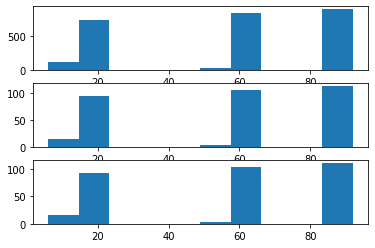

In [13]:
# # analize classes distributino
fig, ax = plt.subplots(3, 1)

ax[0].hist(targets[trainIdx])
ax[1].hist(targets[valIdx])
ax[2].hist(targets[testIdx])

In [14]:
# # Spliting the data

# # print(torch_dataset_lazy.__len__())

totalSize = torch_dataset_lazy.__len__()

# totalSize = totalSize
# # print(totalSize)

# selecting train splitting
# train_size = int(0.8 * totalSize)
train_size = trainIdx.shape[0]
#print(train_size)

# # getting test splitting
# validation_size = math.floor((totalSize - train_size)/3)
validation_size = valIdx.shape[0]
# #print(validation_size)

# # getting test splitting
# test_size = totalSize - train_size - validation_size
test_size = testIdx.shape[0]
# #print(test_size)

# # spliting the torch dataset
# trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(
#     torch_dataset_lazy, 
#     [train_size, validation_size, test_size],
    
#     # set seed
#     generator = torch.Generator().manual_seed(seed)
# )

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
totTmp = train_size+ validation_size + test_size
print("sum: ", totTmp)
assert torch_dataset_lazy.__len__() == totTmp, "dataset partition should be the same"

train size: 2620
validation size:  328
test size: 328
sum:  3276


## Create a dataloader

In [15]:
print("initila distribution")
# initialClassesDistribution = countClasses(trainDataset, only_these_labels)
initialClassesDistribution = np.unique(targets, return_counts=True)[1]

print(initialClassesDistribution)

# fig, ax = plt.subplots()
# ax.bar(x = np.arange(len(only_these_labels)), height = initialClassesDistribution)

initila distribution
[ 157  927   36 1042  733  381]


In [16]:
# # Create data loader (minibatches)

# training loader
trainLoader = torch.utils.data.DataLoader(
    torch_dataset_lazy, 
    batch_size = batch_training_size, 
    # to balance classes
    sampler=ImbalancedDatasetSampler(
        torch_dataset_lazy, 
        indices = trainIdx,
#         indices = [0, 1, 2]
    ),
    # each worker retrieve data from disk, so the data will be ready to be processed by main process. The main process should get the data from disk, so if workers > 0, the workers will get the data (not the main process)
    num_workers = 4,
    
    # https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
    # the dataloader loads the data in pinned memory (instead of pageable memory), avoiding one process (to transfer data from pageable memory to pinned memory, work done by CUDA driver)
    pin_memory = True,
)


# validation loader
validationLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
    batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = torch.utils.data.SubsetRandomSampler(
        valIdx
    ),
)

# # test loader
# testLoader = torch.utils.data.DataLoader(testDataset)
testLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
#     batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = torch.utils.data.SubsetRandomSampler(
        testIdx
    ),
)

In [17]:
print("balanced distribution")
balancedClassesDistribution = countClasses(trainLoader, only_these_labels)

print(balancedClassesDistribution)
# fig, ax = plt.subplots()
# ax.bar(x = np.ar# return 0# return 0ange(6), height = balancedClassesDistribution)
# ax.bar(x = only_these_labels, height = temp2, width = 10)

balanced distribution
[432. 417. 413. 460. 468. 430.]


In [18]:
# save ids of dataset to use (train, test and validation)
saveLightCurvesIdsAfterBalancing(trainLoader, train_size, testLoader, test_size, validationLoader, validation_size, path = folder_path)

light curves ids saved on a file


In [19]:
# # load ids dictionary
# a_file = open(folder_path + "/dataset_ids_after_balancing.pkl", "rb")
# output = pickle.load(a_file)
# print(output["validation"])

## Create experiment parameters file

In [20]:
# store varibales on file
if trainingOnGuanaco or trainWithJustPython:
    text_file = open("../" + expPath + "/experimentParameters.txt" , "w")
    text = "N° experiment: {7}\n General comment: {13}\n Classes: {0}\n train_size: {9}\n validation_size: {10}\n test_size: {11}\n total dataset size: {12}\n Epochs: {8}\n Latent dimension: {1}\n Hidden dimension: {2}\n Input dimension: {3}\n Passband: {4}\n Learning rate: {5}\n Batch training size: {6}\n initial train classes distribution: {14}\nbalanced train class distribution: {15}".format(only_these_labels, latentDim, hiddenDim, inputDim, passband, learning_rate, batch_training_size, number_experiment, epochs, train_size, validation_size, test_size, train_size + validation_size + test_size, comment, initialClassesDistribution, balancedClassesDistribution)
    text_file.write(text)
    text_file.close()
    print("experiment parameters file created")

## Defining parameters to Autoencoder

In [21]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

# passband = passband

num_classes = len(only_these_labels)

if trainWithPreviousModel:
    
    # loadgin model
    model = torch.load(pathToSaveModel + ".txt").to(device = cuda_device)
    
    print("loading saved model")
    
else:
    
    # defining model
    model = EncoderClassifier(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim, num_classes = num_classes, passband = passband, includeDeltaErrors = includeDeltaErrors)

    # mdel to GPU
    model = model.to(device = cuda_device)
    
    print("creating model with default parameters")

creating model with default parameters


In [22]:
print(model)

EncoderClassifier(
  (pconv1): PartialConv(
    (input_conv): Conv1d(6, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(6, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv3): PartialConv(
    (input_conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (hidden1): Linear(in_features=768, out_features=100, bias=True)
  (outputLayer): Linear(in_features=100, out_features=6, bias=True)
  (activationConv): ReLU()
  (activationLinear): Tanh()
)


### Training

starting the training
epoch:    0 / 100
training
invalid input detected at iteration  0
loss:  tensor(1.7990, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  1.799015998840332
invalid input detected at iteration  0
loss:  tensor(1.7945, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  3.5935068130493164
invalid input detected at iteration  0
loss:  tensor(1.7948, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  5.388279557228088
invalid input detected at iteration  0
loss:  tensor(1.7900, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  7.17830765247345
invalid input detected at iteration  0
loss:  tensor(1.7935, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  8.971843838691711
invalid input detected at iteration  0
loss:  tensor(1.7970, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  10.768799424171448
invalid input detected at iteration  0
loss:  tensor(1.7899, device='cuda:0', grad_fn=<NllLossBack

invalid input detected at iteration  2
loss:  tensor(1.7925, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  25.09838116168976
invalid input detected at iteration  2
loss:  tensor(1.7903, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  26.888702750205994
invalid input detected at iteration  2
loss:  tensor(1.7875, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  28.676236987113953
invalid input detected at iteration  2
loss:  tensor(1.7902, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  30.46647584438324
invalid input detected at iteration  2
loss:  tensor(1.7902, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  32.25663197040558
invalid input detected at iteration  2
loss:  tensor(1.7936, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  34.05018854141235
invalid input detected at iteration  2
loss:  tensor(1.7873, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  35.83746314048767
inva

invalid input detected at iteration  5
loss:  tensor(1.7983, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  1.7983028888702393
invalid input detected at iteration  5
loss:  tensor(1.7866, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  3.5848798751831055
invalid input detected at iteration  5
loss:  tensor(1.7889, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  5.373755931854248
invalid input detected at iteration  5
loss:  tensor(1.7908, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  7.164578318595886
invalid input detected at iteration  5
loss:  tensor(1.7923, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  8.956841826438904
invalid input detected at iteration  5
loss:  tensor(1.7879, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  10.744697570800781
invalid input detected at iteration  5
loss:  tensor(1.7955, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  12.540169358253479
in

epoch train loss:  25.08562445640564
invalid input detected at iteration  7
loss:  tensor(1.7912, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  26.87686312198639
invalid input detected at iteration  7
loss:  tensor(1.7918, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  28.668689250946045
invalid input detected at iteration  7
loss:  tensor(1.7922, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  30.46090030670166
invalid input detected at iteration  7
loss:  tensor(1.7869, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  32.24783647060394
invalid input detected at iteration  7
loss:  tensor(1.7903, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  34.038151144981384
invalid input detected at iteration  7
loss:  tensor(1.7897, device='cuda:0', grad_fn=<NllLossBackward>)
epoch train loss:  35.82780158519745
invalid input detected at iteration  7
loss:  tensor(1.7920, device='cuda:0', grad_fn=<NllLossBackward>)
epoc

Exception ignored in: <function _releaseLock at 0x7feb35c2c050>
Traceback (most recent call last):
  File "/home/leo/anaconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 85943, 85944, 85945) exited unexpectedly

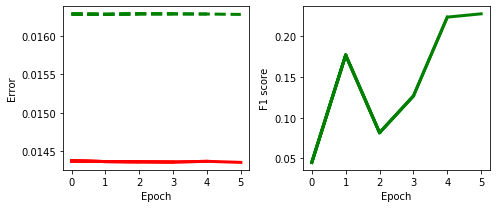

In [40]:
from sklearn.metrics import f1_score

# optimizera
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.5)

# loss function
lossFunction = nn.CrossEntropyLoss()

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# f1 scores
f1Scores = np.zeros((epochs, ))

# min global test loss 
minTestLossGlobalSoFar = float("inf")

# # # loss plot
# if it is not cluster
if (not trainingOnGuanaco) or (not trainWithJustPython):
    
    # add f1 and loss plots
    fig, ax = plt.subplots(1, 2, figsize = (7, 3), tight_layout = True)
    # # fig, ax = plt.subplots()
    
    # error
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Error")
    
    
    # f1 score
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("F1 score")
    

# early stopping
prior_test_error = 0
count_early_stop = 0
threshold_early_stop = 20


print("starting the training")


# epoch
for nepoch in range(epochs):
        
    print("epoch:    {0} / {1}".format(nepoch, epochs))
    
    
    
     
    ######## Train ###########
    epoch_train_loss = 0
    
    for data_ in trainLoader:
        
        data = data_[0]
        labels = data_[1].to(device = cuda_device)
#         labels = data_[1]
        
        optimizer.zero_grad()
            
        # this take the deltas (time and magnitude)
        data = generateDeltas(data, passband, includeDeltaErrors).type(torch.FloatTensor).to(device = cuda_device)
#         data = generateDeltas(data, passband).type(torch.FloatTensor)

#         # testing tensor size 
#         assert data.shape == torch.Size([batch_training_size, len(passband), 4, 71]), "Shape should be [minibatch size, channels, 4, 71]"
#         print("test ok")
        
        # get model output
        outputs = model.forward(data, includeDeltaErrors)
        
#         # testing output shape size
#         assert outputs.shape == torch.Size([batch_training_size, len(only_these_labels)]), "Shape should be [minibatch, classes]"
#         print("test ok")
    
#         print(np.any(torch.isnan(outputs).numpy()))
        
        # data validation
        if np.any(torch.isnan(outputs).cpu().numpy()) or np.any(torch.isinf(outputs).cpu().numpy()):
            
            print("invalid input detected at iteration ", nepoch)
            
            print("data: ", data)
            
            print("outputs ": outputs)
            
        # loss function
        loss = lossFunction(outputs, mapLabels(labels, only_these_labels).to(device = cuda_device))
        
        # backpropagation
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # add loss value (of the currrent minibatch)
        epoch_train_loss += loss.item()
        
    # get epoch loss value
    train_loss[nepoch] = epoch_train_loss / train_size
    
    
    ##### Validation ########
    
    epoch_test_loss = 0
    
    # check f1 score in each minibatch
    f1Score = 0
    
    batchCounter = 0
    
    # minibatches
    for data_ in validationLoader:
        
        data = data_[0]
        labels = data_[1].to(device = cuda_device)
        
#         data = generateDeltas(data, passband).type(torch.FloatTensor).to(device = cuda_device)
        data = generateDeltas(data, passband, includeDeltaErrors).type(torch.FloatTensor).to(device = cuda_device)
    
        outputs = model.forward(data, includeDeltaErrors)
        
#           # testing output shape size
#         assert outputs.shape == torch.Size([batch_training_size, len(only_these_labels)]), "Shape should be [minibatch, classes]"
#         print("test ok")

        # loss function
        loss = lossFunction(outputs, mapLabels(labels, only_these_labels).to(device = cuda_device))
        
        #  store minibatch loss value
        epoch_test_loss += loss.item()

        # f1 score
        f1Score += f1_score(mapLabels(labels, only_these_labels).cpu().numpy(), torch.argmax(outputs, 1).cpu().numpy(), average = "micro")
        
        # batch counter
        batchCounter += 1
    
    # get epoch test loss value
    test_loss[nepoch] = epoch_test_loss / validation_size
    
    # get epoch f1 score
    f1Scores[nepoch] = f1Score / batchCounter
    
    # plot loss values
    # if it's not cluster
    if (not trainingOnGuanaco) or (not trainWithJustPython):

        # loss values
        ax[0].plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
        ax[0].plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green")
        
        # f1 score values
        ax[1].plot(f1Scores[0: nepoch], linewidth = 3, c = "green")
        
        # plot
        fig.canvas.draw()
    
    
    #### Early stopping #####
    
    
    
    # if new test loss is greater than the older one
    count_early_stop += 1
    if epoch_test_loss > prior_test_error:
        count_early_stop += 1
        print("early stopping counter: ", count_early_stop)
    else: 
        count_early_stop = 0
    
    # update prior test error
    prior_test_error = epoch_test_loss
    
    # analyze early stopping
    if count_early_stop > threshold_early_stop:
        
        print("Early stopping in epoch: ", nepoch)
        text_file = open("../" + expPath + "/earlyStopping.txt", "w")
        metricsText = "Epoch: {0}\n ES counter: {1}\n, Reconstruction test error: {2}".format(nepoch, count_early_stop, epoch_test_loss)
        text_file.write(metricsText)
        text_file.close()
        break
        
        
        
    #### Saving best model ####
    
    # if epoch test loss is smaller than global min
    if test_loss[nepoch] < minTestLossGlobalSoFar:
        
        # update global min
        minTestLossGlobalSoFar = test_loss[nepoch]
        
        # save model
        saveBestModel(model, pathToSaveModel, number_experiment, nepoch, minTestLossGlobalSoFar, expPath)
                
   


    # save losses
    print("saving losses")
    losses = np.asarray([train_loss, test_loss]).T
    np.savetxt("../" + expPath + "/training_losses.csv", losses, delimiter=",")
    

    
    
    # save f1 scores
    print("saving f1 scores")
    np.savetxt("../" + expPath + "/f1Scores.csv", f1Scores, delimiter=",")

    
    
# final message
print("training has finished")

In [36]:
np.any(torch.isnan(outputs).cpu().numpy())

False

In [ ]:
# get metrics on trainig dataset
getConfusionAndClassificationReport(trainLoader, nameLabel = "Train", passband = passband, model = model, staticLabels = only_these_labels, number_experiment = number_experiment, expPath = expPath, includeDeltaErrors = includeDeltaErrors)


# get metrics on validation dataset
getConfusionAndClassificationReport(validationLoader, nameLabel = "Validation", passband = passband, model = model, staticLabels = only_these_labels, number_experiment = number_experiment, expPath = expPath, includeDeltaErrors = includeDeltaErrors)

### Stop execution if it's on cluster

In [ ]:
import sys

if  trainingOnGuanaco or trainWithJustPython:

    sys.exit("Exit from code, because we are in cluster or running locally. Training has finished.")

# Analyzing training

In [26]:
!cat ../experiments/10/seed0/maxClass15k/experimentParameters.txt

N° experiment: 10
 General comment: exp 10 + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + 6 channels + seed 0 + include delta errors + max by class 15000
 Classes: [16, 92, 53, 88, 65, 6]
 train_size: 52360
 validation_size: 6545
 test_size: 6546
 total dataset size: 65451
 Epochs: 100
 Latent dimension: 100
 Hidden dimension: 100
 Input dimension: 72
 Passband: [0, 1, 2, 3, 4, 5]
 Learning rate: 0.001
 Batch training size: 128
 initial train classes distribution: [ 1454 15924  1483 15981 15370 15239]
balanced train class distribution: [8631. 8856. 8723. 8763. 8723. 8664.]

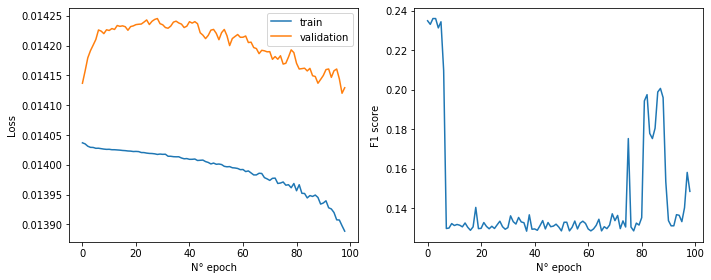

In [27]:
# load losses array
# losses = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/"+ number_experiment + "/seed" + str(seed) + "/training_losses.csv")
losses = pd.read_csv(folder_path + "/training_losses.csv")
# f1 scores
# f1Scores = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass15k" + "/f1Scores.csv")
f1Scores = pd.read_csv(folder_path + "/f1Scores.csv")

# plot losses
fig, ax = plt.subplots(1, 2, figsize = (10,4), tight_layout = True)

# loss
ax[0].set_xlabel("N° epoch")
ax[0].set_ylabel("Loss")
ax[0].plot(losses.iloc[:, 0], label = "train")
ax[0].plot(losses.iloc[:, 1], label = "validation")
ax[0].legend()

# f1 scores
ax[1].set_xlabel("N° epoch")
ax[1].set_ylabel("F1 score")
ax[1].plot(f1Scores)

# best model
# values copied from the txt file
# bestModelEpoch = 785
# bestModelError = 0.00434128265165168
# ax[0].scatter(bestModelEpoch, bestModelError, c = "r", linewidths = 10)
# ax[1].scatter(bestModelEpoch, f1Scores.iloc[bestModelEpoch], c = "r", linewidths = 10)

In [ ]:
!cat ../experiments/9/seed0/maxClass15k/bestScoresModelTraining.txt

In [ ]:
# confusion matrix
import pandas as pd
import seaborn as sn

# select normalization
# norm = {‘true’, ‘pred’, ‘all’}
normalization = "true"

# get confusion matrix
cmTrain = pd.read_csv(tmpLocal + expPath  + '/confusionMatrixTrain_norm_' + normalization + '.csv', header = None) 
cmValidation = pd.read_csv(tmpLocal + expPath + '/confusionMatrixValidation_norm_' + normalization + '.csv', header = None) 

print("Training")
print("Normalization: " + normalization)
sn.heatmap(cmTrain, annot=True)

In [ ]:
print("Validation")
sn.heatmap(cmValidation, annot = True)

In [ ]:
# classification report
!cat ../experiments/9/seed0/maxClass15k/clasificationReportTrain.txt

In [ ]:
# classification report
!cat ../experiments/9/seed0/maxClass15k/clasificationReportValidation.txt